# **Project: Amazon Product Recommendation System**

----------------
**Objective:**
----------------

I am building a recommendation system to recommend products to customers based on their previous ratings for other products. I use a collection of labeled data of Amazon reviews of products. My goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
**Dataset Overview:** 
-----------------------------

The Amazon dataset contains the following attributes which are used:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user

## **Importing the necessary libraries and overview of the dataset**

In [156]:
import surprise as surprise
from surprise import SVD
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from collections import defaultdict

### **Loading data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [157]:
#Loading the Data and adding column names
df = pd.read_csv("/Users/rpravin/Downloads/ratings_Electronics.csv")
print(df.head())
df.info()


df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df.drop('timestamp', axis=1, inplace=True)

    AKM1MP6P0OYPR  0132793040  5.0  1365811200
0  A2CX7LUOHB2NDG  0321732944  5.0  1341100800
1  A2NWSAGRHCP8N5  0439886341  1.0  1367193600
2  A2WNBOD3WNDNKT  0439886341  3.0  1374451200
3  A1GI0U4ZRJA8WN  0439886341  1.0  1334707200
4  A1QGNMC6O1VW39  0511189877  5.0  1397433600
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   AKM1MP6P0OYPR  object 
 1   0132793040     object 
 2   5.0            float64
 3   1365811200     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


**Many users have only rated a few products and some products are rated by very few users.**

We will be including users who have given at least 50 ratings and products that have at least 5 ratings. 

In [158]:
# Getting the column containing the users
users = df.user_id

# Creating a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise set rating count to 1
    else:
        ratings_count[user] = 1

In [159]:
# Users with at least 50 ratings considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [160]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary of products to number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [161]:
# Items with at least 5 ratings considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [162]:
# Print a few rows of final dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Checking the number of rows and columns**

In [163]:
print(df_final)

                user_id     prod_id  rating
1309     A3LDPF5FMB782Z  1400501466     5.0
1321     A1A5KUIIIHFF4U  1400501466     1.0
1334     A2XIOXRRYX0KZY  1400501466     3.0
1450      AW3LX47IHPFRL  1400501466     5.0
1455     A1E3OB6QMBKRYZ  1400501466     1.0
...                 ...         ...     ...
7824422  A34BZM6S9L7QI4  B00LGQ6HL8     5.0
7824423  A1G650TTTHEAL5  B00LGQ6HL8     5.0
7824424  A25C2M3QF9G7OQ  B00LGQ6HL8     5.0
7824425   A1E1LEVQ9VQNK  B00LGQ6HL8     5.0
7824426  A2NYK9KWFMJV4Y  B00LGQ6HL8     5.0

[65290 rows x 3 columns]


**Observations: 65,290 rows and 3 columns**

### **Data types**

In [164]:
# Check Data types 
print(df_final.info())


<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB
None


### **Checking for missing values**

In [165]:
# Check for missing values present 
print(df_final.isnull().sum())

user_id    0
prod_id    0
rating     0
dtype: int64


**Observation: No missing values present in dataset**

### **Summary Statistics**

In [166]:
# Summary statistics of 'rating' variable 
print(df_final.describe())


             rating
count  65290.000000
mean       4.294808
std        0.988915
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000


### **Checking the rating distribution**

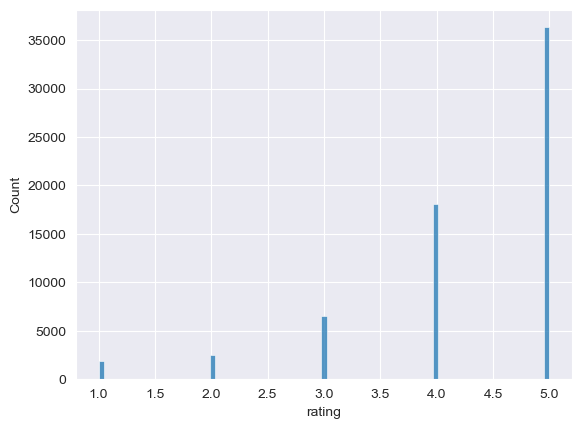

In [167]:
# Create the bar plot and provide observations
ratings_hist = sns.histplot(df_final['rating'])
plt.show()

**Observation: Distribution heavily skewed left as more than half of ratings are five**

### **Checking the number of unique users and items in the dataset**

In [168]:
# Number of total rows in the data 
total_rows = df_final.shape[0]
print("Number of total rows in the data:",total_rows)

# Number of unique user IDs in the data
unique_user_ids = df_final['user_id'].nunique()
print("Number of unique user IDs in the data:",unique_user_ids)

# Number of unique product IDs in the data
unique_prod_ids = df_final['prod_id'].nunique()
print("Number of unique product IDs in the data:",unique_prod_ids)

Number of total rows in the data: 65290
Number of unique user IDs in the data: 1540
Number of unique product IDs in the data: 5689


### **Users with the most number of ratings**

In [169]:
## Top 10 users based on the number of ratings

users = df_final.user_id
ratings_count = dict()
for user in users:
    if user in ratings_count:
        ratings_count[user] += 1
    else:
        ratings_count[user] = 1
ratings_count_df = pd.DataFrame.from_dict(ratings_count,
                                          orient = 'index', columns=['Number_of_ratings'])
ratings_count_df_sorted = ratings_count_df.sort_values(by='Number_of_ratings',
                                                       ascending=False)

print("Top Ten Users with highest number of Ratings\n", "Users:",ratings_count_df_sorted.head())

Top Ten Users with highest number of Ratings
 Users:                 Number_of_ratings
ADLVFFE4VBT8                  295
A3OXHLG6DIBRW8                230
A1ODOGXEYECQQ8                217
A36K2N527TXXJN                212
A25C2M3QF9G7OQ                203


## **Model 1: Rank Based Recommendation System**

In [170]:
# Calculating average rating for each product 
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculating count of ratings for each product
rating_count = df_final.groupby('prod_id')['rating'].count()

# Creating dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'average_rating': average_rating,
                             'rating_count': rating_count})

# Sorting dataframe by average of ratings in descending order
final_rating_sorted = final_rating.sort_values(by='average_rating', ascending=False)

# Printing first 10 records of the "final_rating" dataset
print(final_rating_sorted.head(10))


            average_rating  rating_count
prod_id                                 
B00LGQ6HL8             5.0             5
B003DZJQQI             5.0            14
B005FDXF2C             5.0             7
B00I6CVPVC             5.0             7
B00B9KOCYA             5.0             8
B003CK10DG             5.0             5
B003B41XYO             5.0             5
B0007WK8KS             5.0             6
B0084FM5JC             5.0             5
B005GI2VMG             5.0            10


In [171]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def get_top_n_products(df, n,minn):
    average_rating = df.groupby('prod_id')['rating'].mean()
    rating_count = df.groupby('prod_id')['rating'].count()
    final_rating = pd.DataFrame({'average_rating': average_rating, 'rating_count': rating_count})
    # Finding products with minimum number of interactions
    min_interactions = minn
    min_interactions_products = final_rating[final_rating['rating_count'] >= min_interactions]
    # Sorting values with respect to average rating
    top_n_products = min_interactions_products.sort_values(by='average_rating', ascending=False).head(n)
    return top_n_products


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [172]:
top_5_products_50 = get_top_n_products(df_final, 5,50)
print("Top 5 products with 50 minimum interactions based on popularity:\n", top_5_products_50)


Top 5 products with 50 minimum interactions based on popularity:
             average_rating  rating_count
prod_id                                 
B001TH7GUU        4.871795            78
B003ES5ZUU        4.864130           184
B0019EHU8G        4.855556            90
B006W8U2MU        4.824561            57
B000QUUFRW        4.809524            84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [173]:
top_5_products_100 = get_top_n_products(df_final, 5,100)
print("Top 5 products with 100 minimum interactions based on popularity:\n",top_5_products_100)

Top 5 products with 100 minimum interactions based on popularity:
             average_rating  rating_count
prod_id                                 
B003ES5ZUU        4.864130           184
B000N99BBC        4.772455           167
B002WE6D44        4.770000           100
B007WTAJTO        4.701220           164
B002V88HFE        4.698113           106


Recommending the **top 5** products using the popularity recommendation system. 

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [174]:
from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic


**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**Creating a function to output precison, recall, and f-1 score of any given input of classification model**

In [175]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

Loading the **`rating` dataset** which is a **pandas DataFrame** into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by suprise library

In [176]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.30, random_state=42)


Now **ready to build the first baseline similarity-based recommendation system** using cosine similarity

### **Building the user-user Similarity-based Recommendation System**

In [177]:
# Declaring similarity options
sim_options = {'name': 'cosine',
               'user_based': True}


# Initialize KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)


# Fit model on training data
sim_user_user.fit(trainset)


# Compute precision, recall, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)


RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**Acheived F_1 score(harmonic mean of precision and recall) of 0.82**

Now **predicting rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`**. This user has already interacted with or watched the product with productId '1400501466' and given a rating of 5.

In [178]:
# Predicting rating for a random user with an already interacted product
sim_user_user.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Predicted rating is 4.29 while actual rating was 5 showing room for improvement**

Making a **list of users who have not seen random product with product id "1400501466"**.

In [179]:
# Finding unique user_id where prod_id is not equal to "1400501466"
#Below is the list of users who have not seen the product with product id "1400501466".
filtered_df = df[df['prod_id'] != "1400501466"]
unique_user_ids = filtered_df['user_id'].unique()
print(unique_user_ids)
unique_user_ids_df = pd.DataFrame(unique_user_ids, columns=['User_ID'])


['A3BY5KCNQZXV5U' 'AT09WGFUM934H' 'A32HSNCNPRUMTR' ... 'AT53ZTTO707MB'
 'A1X3ESYZ79H59E' 'A328S9RN3U5M68']


Picking random **user "A34BZM6S9L7QI4" who has not seen the product with productId "1400501466" to test model**.

**Predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.** 

In [180]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)
#observation: 

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Predicted rating was still 4.29, showing model is predicting same rating for users regardless of interaction with products, model has a lot of room for improvement**

### **Improving the similarity-based recommendation system by tuning its hyperparameters**

Tuning hyperparameters of `K-Nearest-Neighbors` algorithm



In [181]:
# Setting up parameter grid to tune hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [True], "min_support":[2,4]}
              }

# Performing 3-fold cross-validation to tune hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)


# Fitting data
gs.fit(data)
# Best RMSE score
print(gs.best_score['rmse'])

# Getting combination of parameters that gave best RMSE score
print(gs.best_params['rmse'])


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.9794494047640508
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Getting optimal values for each of the hyperparameters

Building **final model using tuned values of the hyperparameters**, received from **grid search cross-validation**.

In [182]:
# Using optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'user_based': True, "min_support":2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=20, min_k=3,
                                   random_state=1, verbose=False)

# Training algorithm on trainset
sim_user_user_optimized.fit(trainset)

# Computing precision and recall with k=10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9803
Precision:  0.84
Recall:  0.803
F_1 score:  0.821


**Grid search revealed optimal hyperparameters made model with F_1 score of 0.815**

### 
**First, predicting rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model.**
**Second, predicting rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"` using the optimized model.**
**Lastly, comparing the output with the output from the baseline model.**

In [183]:
# Using sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [184]:
# Using sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict('A34BZM6S9L7QI4',1400501466, verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Both Models predicted 4.29 rating for both, which is the overall mean rating. This shows that the class imbalance revealed during EDA is too greatly affecting both models to get accurate predictions**

### **Identifying similar users to a given user (nearest neighbors)**

Finding **similar users to a given user** or its **nearest neighbors** based on K-Nearest-Neighbors algorithm. Finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [185]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0,5)


[29, 14, 408, 64, 411]

### **Implementing recommendation algorithm based on optimized K-Nearest-Neighbors model**

Creating a function where input parameters are:

- data: a dataset
- user_id: a user id **for which we want the recommendations**
- top_n: the **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [186]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating empty list to store the recommended product ids
    recommendations = []
    
    # Creating user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting product ids which the user_id has not interacted with yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted with yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids for this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)
    
    # Returning top n highest predicted rating products for this user
    return recommendations[:top_n] 

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [187]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final,'A3LDPF5FMB782Z', 5, sim_user_user)
print(recommendations)

[('B00001W0DI', 5), ('B00002EQCW', 5), ('B00003006R', 5), ('B00004W3ZQ', 5), ('B00004WCFT', 5)]


In [188]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
reccomend_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

Above are the results of **similarity-based collaborative filtering** where similarity is calculated **between users**. Now trying similarity-based collaborative filtering where similarity is seen **between items**. 

In [189]:
# Declaring similarity options
sim_options = {'name': 'pearson',
               'user_based': False}
# KNN algorithm used to find desired similar items. Using random_state=1
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Training algorithm on the trainset, and predicting ratings for the test set
sim_item_item.fit(trainset)

# Computing precision, recall, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)
#Observation: 

RMSE: 1.0377
Precision:  0.833
Recall:  0.789
F_1 score:  0.81


**When grouping users by their similar rating habits to predict ratings the F_1 score of the model is 0.81 performing similarly to previous models built**

**Predicting a rating for a random user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** where the user has already interacted or watched the product with productId "1400501466".

In [190]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Predicted rating was 4.29, actual rating was 5**

**Predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [191]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Predicted rating is still 4.29, which is mean of all ratings**

### **Hyperparameter tuning the item-item similarity-based model**


In [192]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd',"cosine"],
                              'user_based': [False], "min_support":[2,4]}
              }



# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Finding best RMSE score
print(gs.best_score['rmse'])

# Finding combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing t

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity mat

Building **final model** using **tuned values of the hyperparameters** from grid search cross-validation.

### **Using the best parameters from GridSearchCV to build the optimized item-item similarity-based model and comparing the performance of the optimized model with the baseline model.**

In [193]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False, "min_support":2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=6, random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Computing precision, recall, f1_score, and RMSE
precision_recall_at_k(sim_item_item_optimized)
#observation: After grid search and using optimal parameters item-item similarity
#model had F-1 score of 0.815 showing predicting rating of item by using items similar to item produces ok model

RMSE: 0.9783
Precision:  0.833
Recall:  0.799
F_1 score:  0.816


**After grid search and using optimal parameters item-item similarity model had F-1 score of 0.816 showing predicting rating of item, by using items that are similar to item produces similar model to previously created models**

### **Steps:**
- **1. Predicting rating for user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using optimized model**
- **2. Predicting rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, using the optimized model**
- **3. Comparing the output with the output from baseline model**

In [194]:
# Using sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=False)


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [195]:
# Using sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict('A34BZM6S9L7QI4', 1400501466, verbose=False)


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Both models still predicting same rating for item, 4.29 which is the mean of all ratings**

### **Identifying similar items to a given item using K-Nearest-Neighbors**

Finding **similar items** to a given item or its nearest neighbors using **K-Nearest-Neighbors**. Finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [196]:
sim_item_item_optimized.get_neighbors(0, k=5)



[315, 1282, 534, 189, 405]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**


In [197]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine
recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item)


In [198]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recc_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
print(recc_df)

      prod_id  predicted_ratings
0  1400532655           4.291403
1  1400599997           4.291403
2  9983891212           4.291403
3  B00000DM9W           4.291403
4  B00000J1V5           4.291403


**Similarity-based collaborative filtering algorithms all performed similarly**, now trying **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**

In [199]:
# Using SVD matrix factorization. Using random_state = 1
svd = SVD(random_state=1)

# Training algorithm on the trainset
svd.fit(trainset)

# Using function precision_recall_at_k to compute precision, recall, F1-Score, and RMSE
precision_recall_at_k(svd)


RMSE: 0.8989
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


**SVD model has a F-1 score of 0.827 highest seen so far in all models**

**Predicting rating for a random user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [200]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.270673152607236, details={'was_impossible': False})

**Predicted rating was 4.27 while actual rating was 5, however SVD model is not predicting 4.29 the mean of all ratings like previous models **

**Predicting rating for the random user `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [201]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.54   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.538853147066661, details={'was_impossible': False})

**Predicted rating for a product that the user had not interacted with was 4.54**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Tuning three hyperparameters:
- **n_epochs**: The number of iterations of the SVD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [202]:
# Setting the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computin

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done co

**Building final model** using **tuned values** of the hyperparameters from grid search cross-validation.

In [203]:
# Building optimized SVD model using optimal hyperparameters and random_state=1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Training algorithm on trainset
svd_optimized=svd_optimized.fit(trainset)

# Using function precision_recall_at_k to compute precision, recall, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8899
Precision:  0.862
Recall:  0.796
F_1 score:  0.828


**Using optimized hyperparameters from grid search f-1 score was 0.828, the best model so far**

### **Steps:**
- **1. Predicting rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using optimized model**
- **2. Predicting rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"` using optimized model**
- **3. Comparing the output with the output from the baseline model**

In [204]:
# Using svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', 1400501466, r_ui=2, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 2.00   est = 4.25   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=2, est=4.254722240912163, details={'was_impossible': False})

In [205]:
# Using svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.51   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.509731219634886, details={'was_impossible': False})

### **Conclusion and Recommendations**

In [206]:
#Overall SVD models worked better than using k-nearest algorithm to group users to predict rating or group items to predict rating. Both methods of grouping made very similar models which performed almost the same. The dataset is heavily imbalanced as more than half the ratings are 5, this is probably what is causing all models to consistently predict ratings greater than 4 and similar to the overall mean of all ratings. To better train the models in the future I would want to create a dataset through bootstrapping or synthetically made dataset where minority classes of ratings are oversampled through simple random replacement.